In [1]:
from functools import cached_property
from typing import Tuple

import attr
import attrs
import cirq
import matplotlib.pyplot as plt
import numpy as np
from cirq.contrib.svg import SVGCircuit
from cirq.ops.greedy_qubit_manager import GreedyQubitManager
from numpy.typing import NDArray
import openfermion as of

from qualtran import BoundedQUInt, Register, drawing
from qualtran._infra.adjoint import Adjoint
from qualtran._infra.gate_with_registers import get_named_qubits
from qualtran.bloqs.chemistry.ising import get_1d_ising_hamiltonian
from qualtran.bloqs.mcmt import And, MultiAnd, MultiControlPauli
from qualtran.bloqs.multiplexers.select_pauli_lcu import SelectPauliLCU
from qualtran.bloqs.qubitization_walk_operator import (
    QubitizationWalkOperator,
    ReflectionUsingPrepare,
)
from qualtran.bloqs.qubitization_walk_operator_test import SelectPauliLCU
from qualtran.bloqs.select_and_prepare import PrepareOracle
from qualtran.bloqs.state_preparation import PrepareUniformSuperposition


def get_ising_chain_select(num_sites):
    ham = get_1d_ising_hamiltonian(qubits=cirq.LineQubit.range(num_sites))
    q = sorted(ham.qubits)
    ham_dps = [ps.dense(q) for ps in ham]
    selection_reg_size = int(np.ceil(np.log2(len(ham_dps))))

    select = SelectPauliLCU(selection_reg_size, select_unitaries=ham_dps, target_bitsize=len(q))
    return select


@attrs.frozen
class UniformPrepareOracle(PrepareOracle):
    r"""Wrapper of PrepareUniformSuperposition to use it as qubitization oracle"""

    n: int

    @property
    def selection_registers(self) -> Tuple[Register, ...]:
        reg = Register(
            name="selection",
            dtype=BoundedQUInt(bitsize=(self.n - 1).bit_length(), iteration_length=self.n),
        )
        return (reg,)

    def decompose_from_registers(
        self,
        *,
        context: cirq.DecompositionContext,
        **quregs: NDArray[cirq.Qid],  # type:ignore[type-var]
    ) -> cirq.OP_TREE:
        return PrepareUniformSuperposition(self.n).on(*quregs["selection"])


bloq_types_to_decompose = (
    SelectPauliLCU,
    ReflectionUsingPrepare,
    UniformPrepareOracle,
    PrepareUniformSuperposition,
    MultiControlPauli,
    MultiAnd,
)


def check(binst):
    b = binst.bloq
    if isinstance(b, Adjoint):
        b = b.subbloq
    if isinstance(b, bloq_types_to_decompose):
        return True
    else:
        return binst.bloq.supports_decompose_bloq()

def clean_and(op):
    if not op.gate.cv1:
        yield cirq.X.on(op.qubits[0])
    if not op.gate.cv2:
        yield cirq.X.on(op.qubits[1])
    yield cirq.TOFFOLI.on(*op.qubits)
    if not op.gate.cv1:
        yield cirq.X.on(op.qubits[0])
    if not op.gate.cv2:
        yield cirq.X.on(op.qubits[1])

def clean_optree(circuit):
    for op in circuit.all_operations():
        s = repr(op)
        if s.find("Free") != -1 or s.find("Allocate") != -1:
            continue
        if s.startswith("And"):
            yield from clean_and(op)
            continue
        # if s.find("uncompute=True") != -1:
        #     yield And(cv1=op.gate.cv1, cv2=op.gate.cv2).on(*op.qubits)
        #     continue
        yield op

/Users/stefano/git_repositories/forks/Qualtran/.conda/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## SELECT

In [8]:
num_sites = 4
select = get_ising_chain_select(num_sites)
select_flattened = select.decompose_bloq().flatten(check)
drawing.show_bloqs([select_flattened])

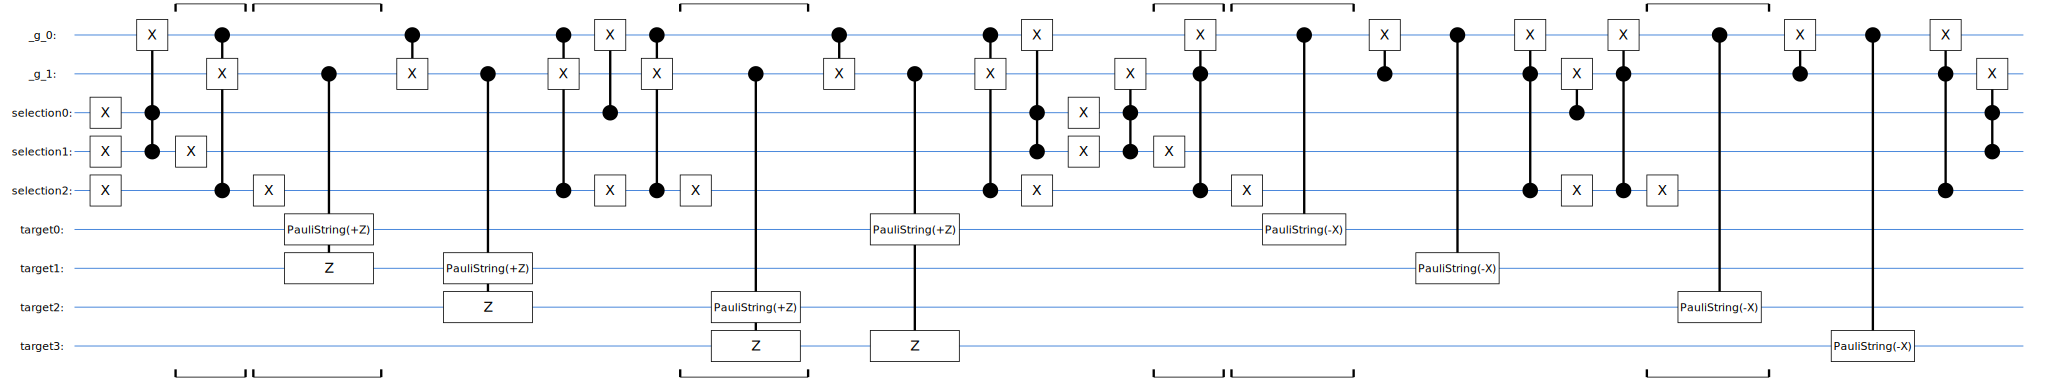

In [9]:
qubit_manager = GreedyQubitManager('_g')
quregs = get_named_qubits(select.signature)
select_circuit, _ = select_flattened.to_cirq_circuit(qubit_manager, **quregs)
clean_circuit = cirq.Circuit(clean_optree(select_circuit))
SVGCircuit(clean_circuit)

qubit order:  _g_0  _g_1  _g_2  selection0  selection1  selection2  target0  target1  target2  target3


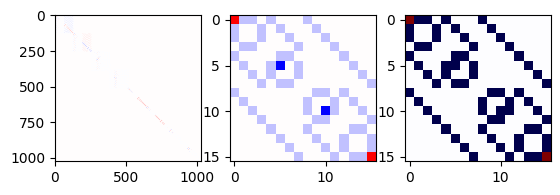

In [28]:
ancilla_N = 2 ** (
    len(clean_circuit.all_qubits()) - select.selection_bitsize - select.target_bitsize
)
selection_N = 2**select.selection_bitsize
target_N = 2**select.target_bitsize

qubit_order = sorted(clean_circuit.all_qubits())
print('qubit order:', *qubit_order, sep='  ')

select_matr = clean_circuit.unitary(qubit_order=qubit_order)
assert(np.isreal(select_matr).all())
select_tensor = select_matr.reshape([*([ancilla_N, selection_N, target_N] * 2)])

ancilla_state = np.zeros(ancilla_N)
ancilla_state[0] = 1

selection_state = np.ones(selection_N) / np.sqrt(selection_N)

ham = np.einsum(
    "ijaklb, i, k, j, l -> ab",
    select_tensor,
    ancilla_state,
    ancilla_state,
    selection_state,
    selection_state,
)

plt.subplot(1, 3, 1)
plt.imshow(np.real(select_matr), cmap="seismic", vmin=-1, vmax=1)

plt.subplot(1, 3, 2)
plt.imshow(np.real(ham), cmap="seismic", vmin=-1, vmax=1)

pauli_sum_ham = get_1d_ising_hamiltonian(qubits=cirq.LineQubit.range(num_sites))

plt.subplot(1, 3, 3)
plt.imshow(np.real(pauli_sum_ham.matrix()), cmap="seismic", vmin=-1, vmax=1)
plt.show()

# walk

In [17]:
num_sites = 4

prepare = UniformPrepareOracle(num_sites)
drawing.show_bloqs([prepare, prepare.decompose_bloq()])
prepare.selection_registers

(Register(name='selection', dtype=BoundedQUInt(bitsize=2, iteration_length=4), shape=(), side=<Side.THRU: 3>),)

In [18]:
num_sites = 4
select = get_ising_chain_select(num_sites)
prepare = UniformPrepareOracle(2*num_sites)

walk = QubitizationWalkOperator(select, prepare)

drawing.show_bloqs([walk, walk.decompose_bloq()])
drawing.show_bloqs([walk.decompose_bloq().flatten_once(lambda x: True)])

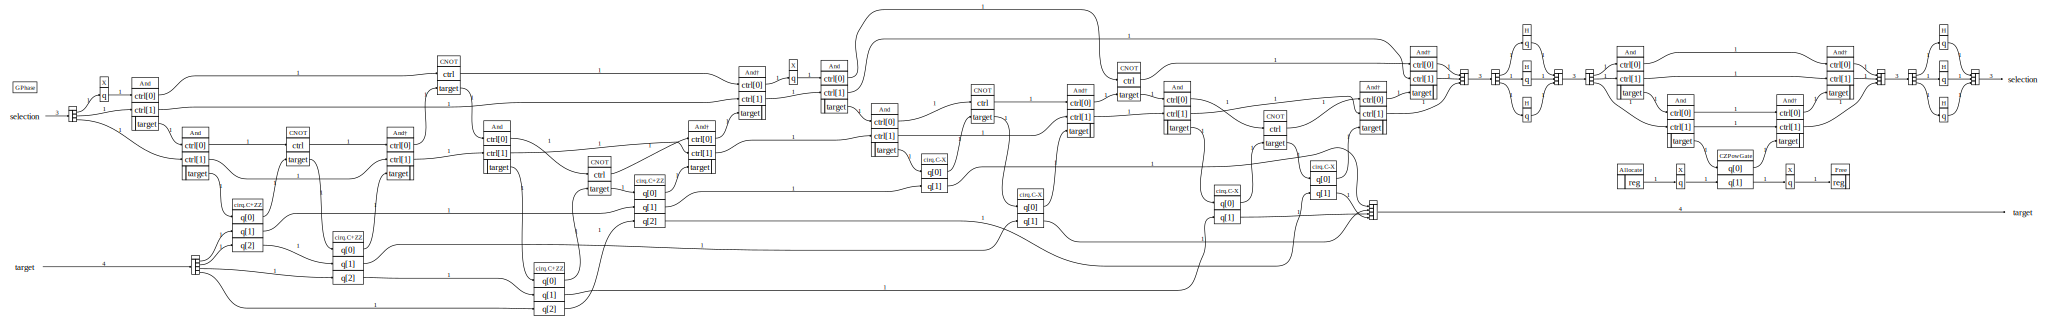

In [19]:
walk_flattened = walk.decompose_bloq().flatten(check)
drawing.show_bloq(walk_flattened)

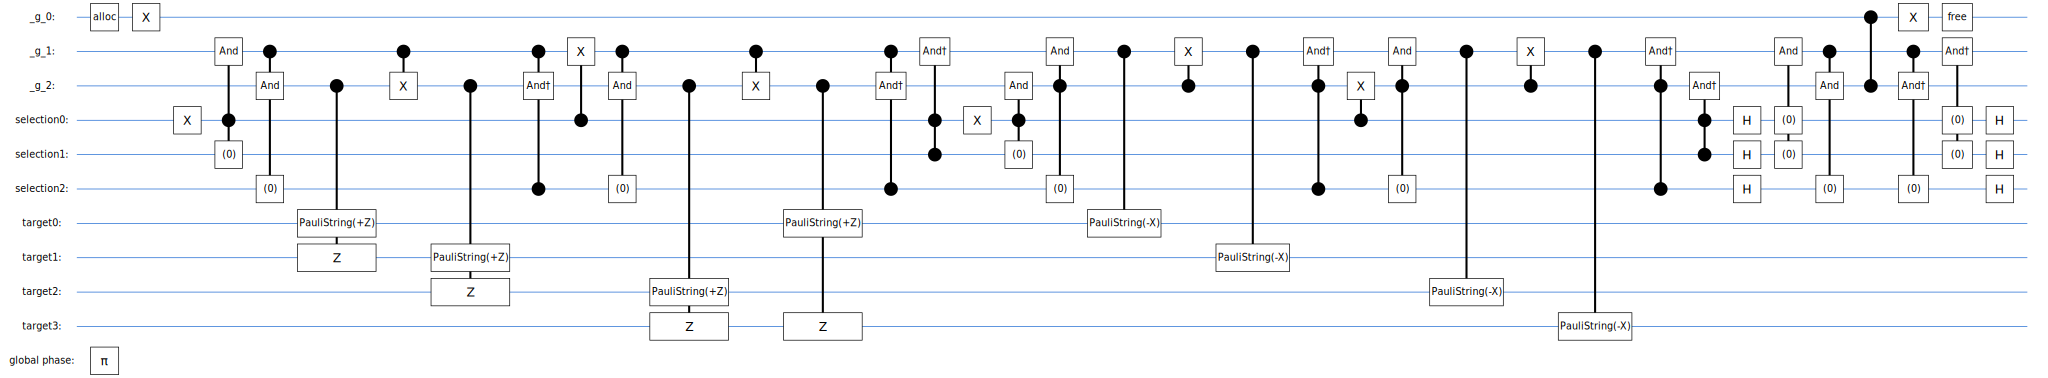

In [20]:
qubit_manager = GreedyQubitManager('_g')
quregs = get_named_qubits(walk.signature)
circuit, _ = walk_flattened.to_cirq_circuit(qubit_manager, **quregs)
SVGCircuit(circuit)

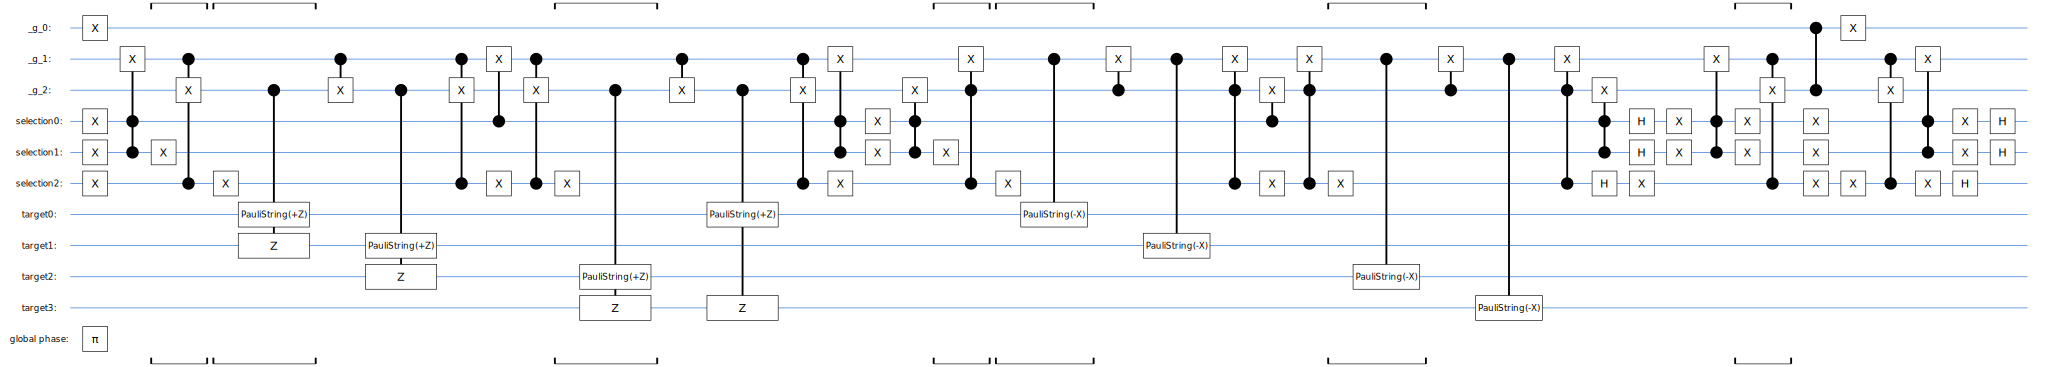

In [21]:
clean_circuit = cirq.Circuit(clean_optree(circuit))
SVGCircuit(clean_circuit)

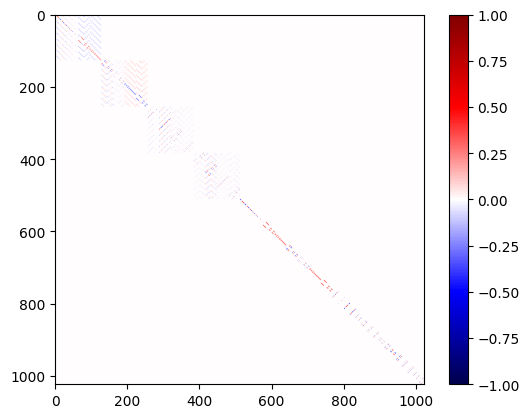

In [22]:
be_matr = clean_circuit.unitary()
assert np.isreal(be_matr).all
be_matr = np.real(be_matr)

plt.imshow(np.real(be_matr), cmap = 'seismic')
plt.colorbar()

qubit order:  _g_0  _g_1  _g_2  selection0  selection1  selection2  target0  target1  target2  target3


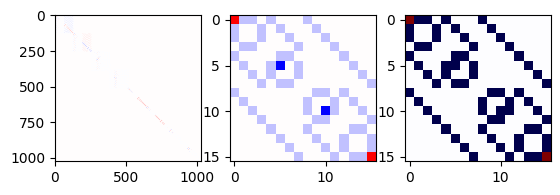

In [27]:
ancilla_N = 2 ** (
    len(clean_circuit.all_qubits()) - walk.select.selection_bitsize - walk.select.target_bitsize
)
selection_N = 2**walk.select.selection_bitsize
target_N = 2**walk.select.target_bitsize

qubit_order = sorted(clean_circuit.all_qubits())
print('qubit order:', *qubit_order, sep='  ')

walk_matr = clean_circuit.unitary(qubit_order=qubit_order)
assert(np.isreal(walk_matr).all())
walk_tensor = walk_matr.reshape([*([ancilla_N, selection_N, target_N] * 2)])

ancilla_state = np.zeros(ancilla_N)
ancilla_state[0] = 1

selection_state = np.ones(selection_N) / np.sqrt(selection_N)

ham = np.einsum(
    "ijaklb, i, k, j, l -> ab",
    walk_tensor,
    ancilla_state,
    ancilla_state,
    selection_state,
    selection_state,
)

plt.subplot(1, 3, 1)
plt.imshow(np.real(walk_matr), cmap="seismic", vmin=-1, vmax=1)

plt.subplot(1, 3, 2)
plt.imshow(np.real(ham), cmap="seismic", vmin=-1, vmax=1)

pauli_sum_ham = get_1d_ising_hamiltonian(qubits=cirq.LineQubit.range(num_sites))

plt.subplot(1, 3, 3)
plt.imshow(np.real(pauli_sum_ham.matrix()), cmap="seismic", vmin=-1, vmax=1)
plt.show()